In [4]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [5]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

# IMPORTING KAGGLE DATA

fine_grained_fruit_quality_assessment_path = kagglehub.competition_download('fine-grained-fruit-quality-assessment')

print('Data source import complete.')


100%|██████████| 1.35G/1.35G [00:16<00:00, 90.6MB/s]

Extracting files...


Data source import complete.


In [30]:
# DATA EXPLORATION

import os
from collections import Counter
# Use the variable that holds the downloaded path, and append the subdirectory structure
data_dir = os.path.join(fine_grained_fruit_quality_assessment_path, 'train', 'train')

# Add a check to see if the directory exists before listing
if not os.path.isdir(data_dir):
    print(f"Error: Directory not found at {data_dir}")
    # You might want to exit or handle this error more gracefully
    # sys.exit(1) # Requires importing sys
else:
    class_counts = {}

    for class_name in os.listdir(data_dir):
        class_folder = os.path.join(data_dir, class_name)
        if os.path.isdir(class_folder):
            num_images = len(os.listdir(class_folder))
            class_counts[class_name] = num_images

    total_images = sum(class_counts.values())

    class_proportions = {class_name: count / total_images for class_name, count in class_counts.items()}

    print("Class Proportions:")
    for class_name, proportion in class_proportions.items():
        print(f"{class_name}: {proportion:.2f}")

Class Proportions:
tomato_half_ripened: 0.01
tomato_green: 0.05
banana_rotten: 0.30
banana_unripe: 0.21
tomato_fully_ripened: 0.01
banana_ripe: 0.22
banana_overripe: 0.21


In [8]:
# DATA LOADING

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#resizing
IMG_SIZE = (224, 224)
#scaling and splits
data = ImageDataGenerator(rescale=1./255, validation_split=0.2) #stratified splits for unbalanced data

# Use the variable containing the downloaded path for the data generators as well
trainData = data.flow_from_directory(
    os.path.join(fine_grained_fruit_quality_assessment_path, 'train', 'train'),
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='sparse', #uses label encoding
    shuffle=True,
    subset='training'
)

valData = data.flow_from_directory(
    os.path.join(fine_grained_fruit_quality_assessment_path, 'train', 'train'),
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='sparse',
    shuffle=False,
    subset='validation'
)

# For the test data, you might need to check the exact structure after download
# It's possible the test data is directly under the downloaded path or in a 'test' subdirectory
# Let's assume it's under 'test' for now, but you might need to adjust this based on the print output
testData = data.flow_from_directory(
    os.path.join(fine_grained_fruit_quality_assessment_path, 'test'),
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Found 5917 images belonging to 7 classes.
Found 1478 images belonging to 7 classes.
Found 2484 images belonging to 1 classes.


**HELPER** **FUNCTIONS** (USED FOR ALL MODELS)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

In [10]:
# Title: Model Compilation
# Description: Compiles the model with the Adam optimizer, sparse categorical crossentropy loss, and accuracy metric.

def compile_model(model):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [40]:
# Title: Callback Generator
# Description: Returns a list of callbacks including EarlyStopping to prevent overfitting and ModelCheckpoint to save the best model weights during training.

from tensorflow.keras import callbacks # Import the callbacks module

def get_callbacks(model_name='baseline'):
    ##checkpoint = callbacks.ModelCheckpoint(
    ##    f'{model_name}_weights.h5',
    ##    save_best_only=True,
    ##    monitor='val_accuracy', mode='max')
    ###
    checkpoint = callbacks.ModelCheckpoint(
    f'{model_name}.weights.h5',  # <- changed _ to .
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True) # <- added this
    # early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    return checkpoint


In [12]:
# Title: Model Training Wrapper
# Description: Trains any given model using training and validation data, applying specified callbacks such as early stopping and checkpointing.

def train_model(model, trainData, valData, model_name='baseline', epochs=30):
    history = model.fit(
        trainData,
        validation_data=valData,
        epochs=epochs,
        callbacks=get_callbacks(model_name)
    )
    return history


In [13]:
# Title: Validation Evaluation & Reporting
# Description: Evaluates the model on the validation set, printing a classification report and displaying a confusion matrix.

def evaluate_model(model, valData, class_indices, model_name='Model'):
    val_preds = np.argmax(model.predict(valData), axis=1)
    y_true = valData.classes
    print(f"Evaluation Report for {model_name}")
    print(classification_report(y_true, val_preds, target_names=class_indices.keys()))
    plot_confusion_matrix(y_true, val_preds, class_indices)


In [14]:
# Title: Confusion Matrix Plotter
# Description: Plots a labeled heatmap confusion matrix comparing predicted vs true labels for easy visual analysis.

def plot_confusion_matrix(y_true, y_pred, class_indices):
    cm = confusion_matrix(y_true, y_pred)
    labels = list(class_indices.keys())
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [15]:
# Title: Training History Plotter
# Description: Plots training and validation accuracy/loss curves over epochs to visualize model performance trends.

def plot_training_history(history):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.show()


In [35]:
# Title: Test Prediction Exporter
# Description: Uses the trained model to predict labels for the test dataset and saves the results in a CSV file formatted for Kaggle submission.

def export_predictions(model, testData, output_filename="Team_CHP_5_predictions.csv"):
    test_preds = np.argmax(model.predict(testData), axis=1)
    filenames = testData.filenames
    df = pd.DataFrame({
        "ImageID": [os.path.basename(f) for f in filenames],
        "Class": test_preds
    })
    df.to_csv(output_filename, index=False)
    print(f"Predictions exported to {output_filename}")


In [36]:
def download_CSV(file_path):
     from google.colab import files
     files.download(file_path)

BASELINE **CNN** Model

In [23]:
# BASELINE CNN MODEL

from tensorflow.keras import layers, models

def build_baseline_model(input_shape, num_classes):
    model = models.Sequential(name="Team_CHP_5_CNN_Baseline")
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


Epoch 1/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4364 - loss: 1.7170

185/185 ━━━━━━━━━━━━━━━━━━━━ 749s 4s/step - accuracy: 0.4371 - loss: 1.7139 - val_accuracy: 0.7645 - val_loss: 0.6756
Epoch 2/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7377 - loss: 0.6614

185/185 ━━━━━━━━━━━━━━━━━━━━ 736s 4s/step - accuracy: 0.7379 - loss: 0.6611 - val_accuracy: 0.7760 - val_loss: 0.6119
Epoch 3/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8050 - loss: 0.5074

185/185 ━━━━━━━━━━━━━━━━━━━━ 757s 4s/step - accuracy: 0.8051 - loss: 0.5073 - val_accuracy: 0.8356 - val_loss: 0.4562
Epoch 4/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8326 - loss: 0.4420

185/185 ━━━━━━━━━━━━━━━━━━━━ 746s 4s/step - accuracy: 0.8327 - loss: 0.4419 - val_accuracy: 0.8586 - val_loss: 0.4035
Epoch 5/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 795s 4s/step - accuracy: 0.8498 - loss: 0.4077 - val_accuracy: 0.8579 - val_loss: 0.3779
Epoch 6/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8635 - loss: 0.3524

185/185 ━━━━━━━━━━━━━━━━━━━━ 720s 4s/step - accuracy: 0.8635 - loss: 0.3525 - val_accuracy: 0.8789 - val_loss: 0.3619
Epoch 7/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8868 - loss: 0.3168

185/185 ━━━━━━━━━━━━━━━━━━━━ 750s 4s/step - accuracy: 0.8868 - loss: 0.3168 - val_accuracy: 0.8945 - val_loss: 0.2909
Epoch 8/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8907 - loss: 0.3014

185/185 ━━━━━━━━━━━━━━━━━━━━ 739s 4s/step - accuracy: 0.8907 - loss: 0.3014 - val_accuracy: 0.8985 - val_loss: 0.2828
Epoch 9/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8944 - loss: 0.2724

185/185 ━━━━━━━━━━━━━━━━━━━━ 727s 4s/step - accuracy: 0.8944 - loss: 0.2725 - val_accuracy: 0.9032 - val_loss: 0.2609
Epoch 10/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8956 - loss: 0.2828

185/185 ━━━━━━━━━━━━━━━━━━━━ 724s 4s/step - accuracy: 0.8957 - loss: 0.2828 - val_accuracy: 0.9100 - val_loss: 0.2481
Epoch 11/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 713s 4s/step - accuracy: 0.8983 - loss: 0.2688 - val_accuracy: 0.9053 - val_loss: 0.2553
Epoch 12/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 741s 4s/step - accuracy: 0.9030 - loss: 0.2566 - val_accuracy: 0.8836 - val_loss: 0.2886
Epoch 13/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9068 - loss: 0.2337

185/185 ━━━━━━━━━━━━━━━━━━━━ 769s 4s/step - accuracy: 0.9069 - loss: 0.2336 - val_accuracy: 0.9175 - val_loss: 0.2272
Epoch 14/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 710s 4s/step - accuracy: 0.9280 - loss: 0.1941 - val_accuracy: 0.9114 - val_loss: 0.2313
Epoch 15/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9225 - loss: 0.1910

185/185 ━━━━━━━━━━━━━━━━━━━━ 713s 4s/step - accuracy: 0.9225 - loss: 0.1911 - val_accuracy: 0.9202 - val_loss: 0.2150
Epoch 16/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 738s 4s/step - accuracy: 0.9131 - loss: 0.2338 - val_accuracy: 0.9181 - val_loss: 0.2339
Epoch 17/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 705s 4s/step - accuracy: 0.9410 - loss: 0.1630 - val_accuracy: 0.8836 - val_loss: 0.3361
Epoch 18/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 704s 4s/step - accuracy: 0.9385 - loss: 0.1636 - val_accuracy: 0.8951 - val_loss: 0.2926
Epoch 19/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9371 - loss: 0.1600

185/185 ━━━━━━━━━━━━━━━━━━━━ 735s 4s/step - accuracy: 0.9371 - loss: 0.1600 - val_accuracy: 0.9222 - val_loss: 0.2534
Epoch 20/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 704s 4s/step - accuracy: 0.9420 - loss: 0.1510 - val_accuracy: 0.9222 - val_loss: 0.2428
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step
Evaluation Report for Team_CHP_5_CNN
                      precision    recall  f1-score   support

     banana_overripe       0.90      0.95      0.92       310
         banana_ripe       0.91      0.90      0.90       320
       banana_rotten       0.96      0.91      0.93       441
       banana_unripe       0.96      0.99      0.98       304
tomato_fully_ripened       0.55      0.55      0.55        11
        tomato_green       0.79      0.95      0.86        74
 tomato_half_ripened       0.33      0.06      0.10        18

            accuracy                           0.92      1478
           macro avg       0.77      0.76      0.75      1478
        weighted avg       0.92      0.92      0.92   

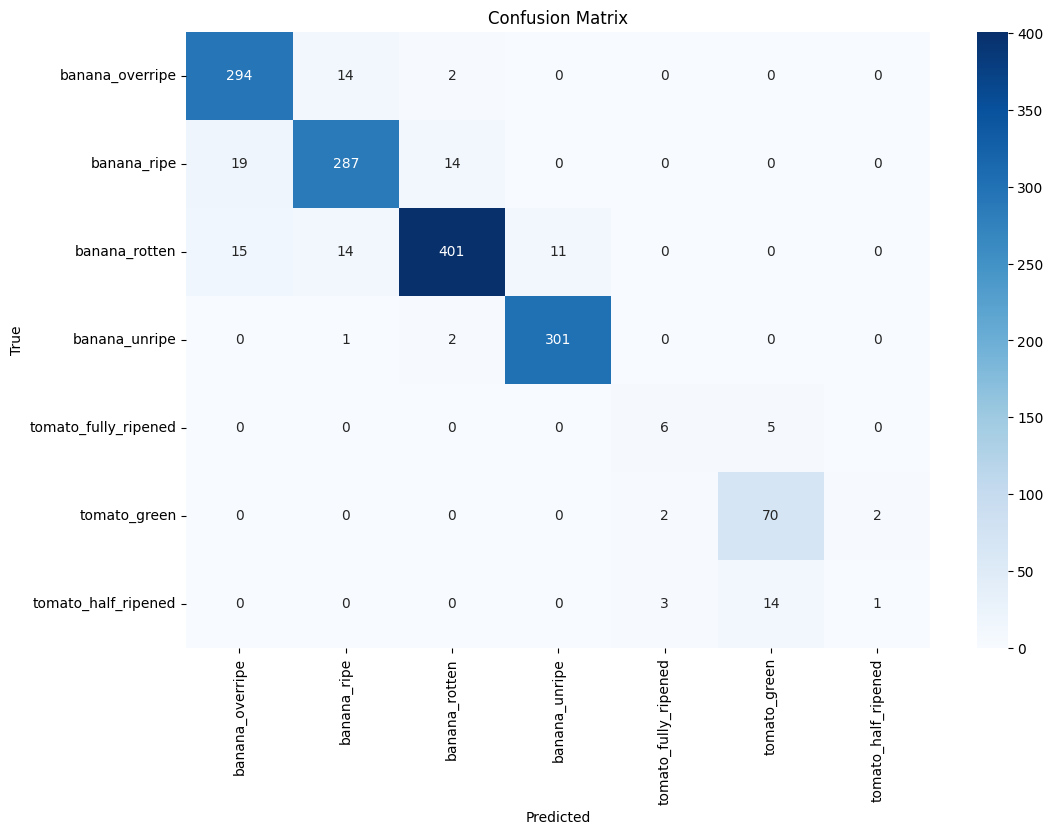

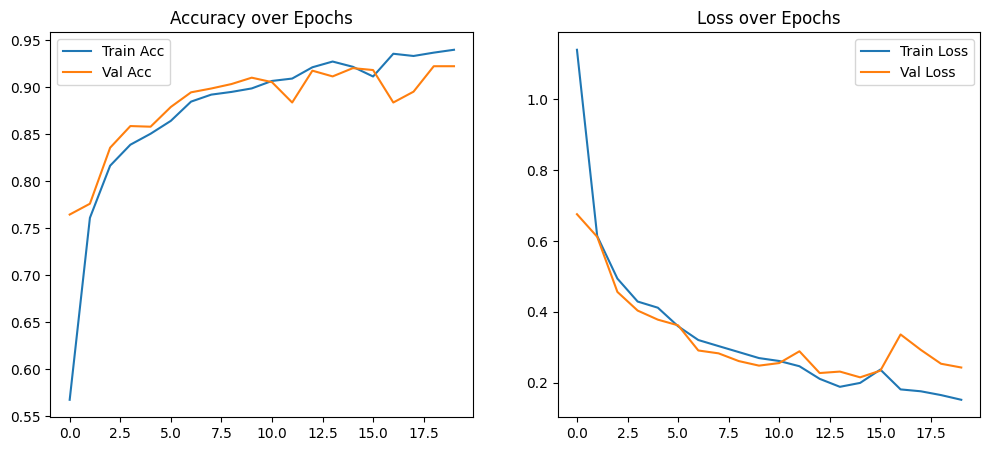

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step
Predictions exported to Team_CHP_5_predictions.csv


In [29]:
# RUN BASELINE CNN MODEL
baseline_model = build_baseline_model(input_shape=(224, 224, 3), num_classes=trainData.num_classes)
baseline_model = compile_model(baseline_model)
baseline_model.summary()
history = train_model(baseline_model, trainData, valData, model_name="Team_CHP_5_CNN", epochs=30)
evaluate_model(baseline_model, valData, class_indices=trainData.class_indices, model_name="Team_CHP_5_CNN")
plot_training_history(history)
export_predictions(baseline_model, testData, output_filename="Team_CHP_5_predictions.csv")

In [39]:
download_CSV("Team_CHP_5_predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>